# O que explica acesso de internet pelo telefone?

Autor: Luís Gustavo Magalhães Venramin

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Logit

%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\Luis Vendramin\Downloads\pnad.csv') # -> Imputar o banco de dados

# Feature Selection

Como estamos trabalhando com dados da PNAD e as variáveis possuem muitos valores qualitativos, trabalhar com muitas variáveis será um problema dado que será necessário um grande número de dummies. Podemos fazer uma filtragem inicial sabendo que estamos perdendo informação mas com o intuíto de estimarmos resultados mais robustos do ponto de vista estatístico.

## 1. Analisando os dados vazios

O problema de variáveis com dados vazios é uma discussão muito longa na estatística e em análise de dados. Caso os dados estejam vazios por motivos "aleatórios", ou seja, não existe uma explicação teórica do porque não foi observada uma informação (principalmente se é explicada pelo conjunto de outras variáveis da amostra), não estaremos incorrendo em grandes problemas se deletarmos a observação ou a vaiável. O que acontecerá é a redução de informação disponível e as nossas estimações serão menos pecisas. Entretanto, se os dados estiverem vazios por algum motivo não aleatório, estaremos incorrendo em um viés se deletarmos a observação. Há diversas formas complexas de lidar com o viés de variável censurada, uma delas é o Modelo de Correção de Heckman. Sabendo disso, podemos prossguir analisando as frequências de missing data na nossa amostra.

In [4]:
(df.apply(lambda x: x.isna().sum())/df.shape[0]).sort_values(ascending=False)

horas_semanais_trabalho            0.537150
ocupacao                           0.496136
idade_inicio_trabalho              0.496136
atividade_agricola                 0.496136
posicao_trabalho                   0.496136
atividade                          0.496136
ocupado                            0.459448
estado_civil                       0.395863
ativo_economicamente               0.135345
responsavel_afazeres_domesticos    0.135345
trabalha                           0.135345
componentes_domicilio              0.001659
rendimento_mensal                  0.001659
condicao_domiciliar                0.000000
raca                               0.000000
idade                              0.000000
alfabetizado                       0.000000
sexo                               0.000000
inss                               0.000000
estuda                             0.000000
internet_via_celular               0.000000
tipo_familia                       0.000000
situacao_censitaria             

------
Como a nossa variável de interesse é internet_via_celular, o tratamento é um pouco mais simples dado que essa variável não apresenta dados vazios, entretanto, temos muitas variáveis com muitos dados faltantes. Podemos tomar algumas atitudes com dados vazios:
    
    a. Deletar a variável
    b. Deletar a observação
    c. Tentar "prever" o valor do dado faltante

A alternativa a. é interessante quando temos muitos dados faltantes para uma mesma variável, que é o caso de: 

    horas_semanais_trabalho, ocupacao, idade_inicio_trabalho, atividade_agricola, posicao_trabalho, atividade, ocupado e estado_civil

Por ter muitos dados vazios, essas variáveis vão possuir pouco valor explicativo reduzido (pouca informação disponível), por mais que elas sejam teoricamente relevantes para estimar a probabilidade internet_via_celular. Se estivermos confrontando um problema de viés de variável censurada, transformamos esse problema em um poblema de variável omitida, que pode ser contornada com variáveis proxys disponíveis.

A alternativa b. é um pouco mais problemática. Se estivermos em um caso de variáveis com dados vazios por motivos não aleatórios, dropar uma observação/linha trará viés. Para as variáveis:

    ativo_economicamente, responsavel_afazeres_domesticos, responsavel_afazeres_domesticos, trabalha, componentes_domicilio e rendimento_mensal
    
faremos uso dessa alternativa conhecendo as suas limitações. Se olharmo, vemos que as 4 primeiras variáveis possuem a mesma quantidade de dados faltantes, o que nos indica que elas podem estar caminhando juntas. Ou seja, se uma pessoa não apresenta informação para uma das variáveis, também não é apresentado para as outras 3. De fato é o que percebemos quando filtramos os dados para as observações que são vazias para a variável ativo_economicamente, vemos que as variáveis também são vazias para as outras 3 variáveis. O que indica que talvez haja uma justificativa para o porquê não haver dados para essas variáveis, não é aleatória a ausência dos dados. Talvez seja um motivo correlacionado com a renda, com a região censitária ou com qualquer outra variável que pode ou não estar incluída nas nossas informações disponíveis. É possível modelar esses dados faltantes com as variáveis que podem estar correlacionadas com elas (como proposto em .c), entretando é algo difícil e que pode gerar resultados imprecisos se feitos de maneira não rigorosa. Para as variáveis componentes_domicilio e rendimento_mensal, por terem uma proporção de dados vazios muito pequenos (menos que 1% de todas as observações), consideraremos que a falta de informação é aleatória.

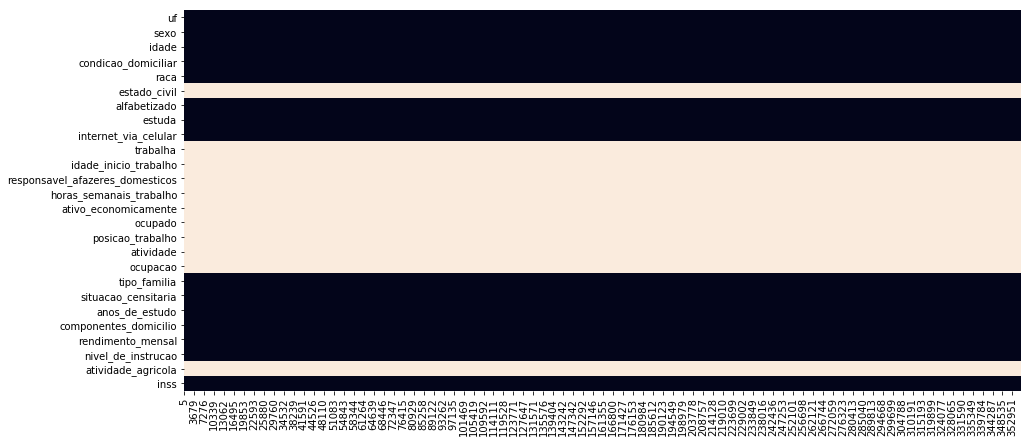

In [5]:
fig, ax = plt.subplots(figsize=(15,7))

df_ativo_economicamente_nan = df.loc[df.ativo_economicamente.isna()]
sns.heatmap(df_ativo_economicamente_nan.isnull().T, cbar=False, ax=ax) # Cada ponto branco corresponde a um dado vazio

In [6]:
# Reformulando os banco de dados com as informações escolhidas

# Dropando variáveis
df = df.drop(['horas_semanais_trabalho', 'ocupacao', 'idade_inicio_trabalho', 
               'atividade_agricola', 'posicao_trabalho', 'atividade', 'ocupado', 'estado_civil'], axis=1)
# Dropando observações
df = df.dropna()

## 2. Analisando a variância das variáveis

Um passo importante para produzirmos bons estimadores, é que haja uma boa variância das nossas variáveis explicativas. Suponha que gostaríamos de ver o que explica o acesso de internet via celular apenas no Acre. Será que o fato de uma pessoa ser branca (aqui inclui os amarelos) teria um bom poder explicativo tão forte como teria se extivessemos analisando o Brasil como um todo? A resposta é: possivelmente não, depende também do quão forte é essa diferença. No Acre, quase 80% da população é PPI e no Brasil há quase um relação de 50%/50% entre PPI e brancos. Dessa forma, no Acre, você não possui variabilidade suficiente na variável raca para poder ter informação tão precisas sobre as diferenças socieconômicas entre esses dois segmentos da população, mas se você analisar o Brasil como um todo, bem possívelmente essa será uma variável relevante.

Dito isso, vamos realizar uma análise gráfica do histograma das variáveis selecionadas até então, com o intuíto de achar uma concentração de valores muito grande dentro de alguma variável. Como temos muitos dados qualitativos, para esses casos vou converter cada possível categoria em um número inteiro. Como não estou interessado no seu valor em si e sim em sua frequência na amostra, isso não será um problema.

Podemos ver 3 variáveis onde há uma grande concentração de valores: alfabetizado, situação_censitária e inss. A baixa variância não é um grande problema, não causa nenhum viés porém pode levar a estimadores com baixa significância, então não seremos muito rigorosos. Porém, um outro problema que surge na análise de dados, é o problema de multicolinearidade, que é quando colocamos duas variáveis explicativas muito correlacionadas. Tal impecilho causa problemas ao diminuir a significância dos estimadores (também não causa viés). No caso, sabemos que a variável inss é muito correlacionada com a idade e alfabetizado é muito correlacionado com anos_de_estudo, dessa forma, como anos_de_estudo e idade são variáveis com maior variância de dados, podemos excluir inss e alfabetizado. Entretanto, anos_de_estudo é muito semelhante a nivel_de_instrução, e é sabido que o impacto na vida de uma pessoa é muito mais determinado se ela concluiu um ciclo escolar como o ensino médio ou a faculdade do que anos de estudo propriamente dito, logo, deletaremos anos_de_estudo também. Não deletaremos situaca_censitaria, porque é uma informação importante e não há outra variável fortemente correlacionada com ela.

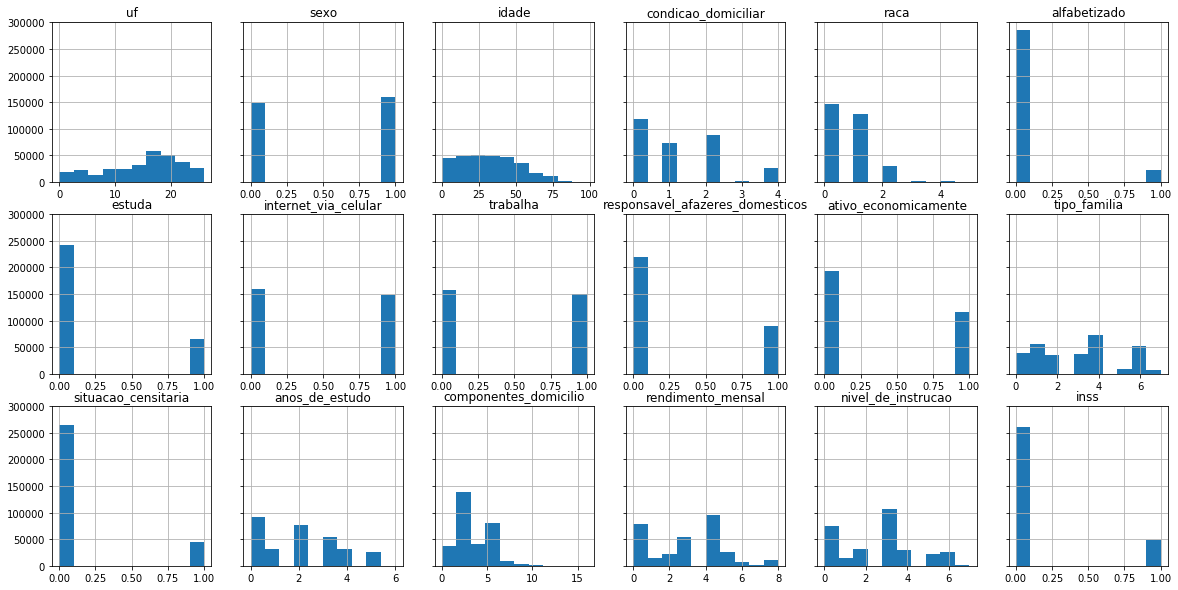

In [7]:
fig, axs = plt.subplots(3,6, figsize=(20, 10), sharey=True)
axs = axs.ravel()
for c in range(len(df.columns)):
    pd.Series(df[df.columns[c]].factorize()[0]).hist(ax=axs[c])
    axs[c].set_title(df.columns[c])

In [8]:
# Reformulando os banco de dados com as informações escolhidas

# Dropando variáveis
df = df.drop(['inss', 'anos_de_estudo', 'alfabetizado'], axis=1)

## 3. Analise exploratória de correlações

Vamos analisar como a frequência de possuir internet via celular muda controlado pelo valor de cada variável. Desse modo, conseguimos ver, de forma não muito rigorosa, se variações no valor da vaiável implica mudanças de acesso da internet via celular. Vamos ter um cheiro inicial. Feito isso, será possível seleconar algumas variáveis que apresentaram boa correlação para fazer um modelo estatístico mais formal e verificar se as variáveis apresentaram valores significativos. Como estamos trabalhado com muitas variáveis categóricas, será necessário o uso de muitas variáveis dummies, o que pode ser um impecilho pois teremos que estimar muitos parâmentros, comendo os nossos graus de liberdade.

In [9]:
for i in df.drop(['internet_via_celular'], axis=1).columns:
    x = (df.groupby(i).internet_via_celular.sum()/df[i].value_counts()).sort_values()
    print(i)
    print(x)
    print()

uf
Maranhao               0.323392
Piaui                  0.354188
Alagoas                0.372458
Tocantins              0.392920
Rondonia               0.408230
Acre                   0.408907
Ceara                  0.431339
Paraiba                0.457891
Rio Grande do Norte    0.464574
Para                   0.464930
Pernambuco             0.472466
Amazonas               0.479497
Bahia                  0.491042
Sergipe                0.499618
Minas Gerais           0.507193
Mato Grosso            0.514888
Espirito Santo         0.525044
Amapa                  0.526582
Parana                 0.526730
Santa Catarina         0.528253
Rio Grande do Sul      0.555321
Goias                  0.569463
Mato Grosso do Sul     0.592312
Rio de Janeiro         0.604653
Roraima                0.608075
Sao Paulo              0.618673
Distrito Federal       0.728372
dtype: float64

sexo
sexo
1    0.506536
0    0.527618
dtype: float64

idade
115    0.000000
94     0.000000
95     0.000000
96     0.

Tomando o desvio padrão das frequência de internet_via_celular controlado por cada variável obtemos que: as variáveis sexo, responsavel_afazeres_domesticos, tipo_familia, uf, condicao_domiciliar e trabalha, são variáveis que quando seus valores mudam a variável internet_via_celular muda pouco.

In [10]:
y = pd.Series()
for i in df.drop(['internet_via_celular'], axis=1).columns:
    x = (df.groupby(i).internet_via_celular.sum()/df[i].value_counts()).sort_values()
    y[i] = x.std()
y.sort_values(ascending=False)

idade                              0.290444
nivel_de_instrucao                 0.276516
situacao_censitaria                0.260910
raca                               0.228861
rendimento_mensal                  0.172414
estuda                             0.167023
ativo_economicamente               0.137284
componentes_domicilio              0.131103
trabalha                           0.112054
condicao_domiciliar                0.105946
uf                                 0.091006
tipo_familia                       0.088783
responsavel_afazeres_domesticos    0.025899
sexo                               0.014907
dtype: float64

## 4. Conclusão

Fazendo apenas simples análises, suspeitamos que as seguintes variáveis são as que melhor explicam o acesso a internet via celular:
    
    1. idade              
    2. nivel_de_instrucao 
    3. situacao_censitaria
    4. raca             
    5. rendimento_mensal
    6. estuda              
    7. ativo_economicamente
    8. componentes_domicilio
    
Cabe aqui quatro considerações das variáveis selecionadas.

Primeiro, a variável raca é melhor tratada se dividirmos a população entre PPI (pretos, pardos e indígenas) somado com os não declarados e Brancos (amarelo e brancos). Dessa forma, vou trabalhar apenas com uma dummy que expressa se a pessoa é branca.

Segundo, a variável rendimento_mensal é extremamente problemática. É sabido que em pesquisas como a PNAD as pessoas mais ricas tendem a mentir sobre o seu real rendimento. Vemos na nossa população que mais de 2% da amostra preferiu não dar informações sobre o seu rendimento e 0,3% da amostra diz não possuir rendimento. Entretando, mais da metade desses dois grupos possuem acesso a internet via celular. Proporção bem maior de quem recebe de 1/4 a 1 salário mínimo. Sabendo dessa limitação, como se trata de poucas observações, preferi eliminar da nossa amostra os casos de pessoas que não declararam rendimento e aquelas que disseram não ter rendimento. O ideal seria trabalhar com uma outra variável que seria uma proxy de renda, mas não temos isso disponível.

Terceiro, a variável componentes_domicilio possui uma relação não linear com internet_via_celular. Percebe-se que há uma relação forte entre essas duas variáveis, mas os impactos são muito confusos. As explicações podem ser devido a baixa frequência de domicilios com muitos membros, o que pode levar a informação pouco precisas e o fato de poder haver casas que moram várias pessoas em uma relação diferente da familiar (varias pessoas dividindo uma casa, por exemplo). Talvez o que melhor explique o poder dessa relação é o fato de o entrevistado ser de uma família que possui filhos ou não, pois isso possui impactos bem relatados pela teoria econômica. Logo, utilizarei a variável condicao_domiciliar para gerar uma dummy que expresse se a família do entrevistado não possui filhos.

Quarto, a variável nivel_de_instrucao poder assumir a categoria "Nao determinado", porém ela tem baixa frequência (aparece em menos de 0,2% dos casos) e atrapalha as conclusões que a variável nivel_de_instrucao pode ter, pois as pessoas que não possuem nivel de intrução determinado possuem acesso a internet em quase 60% dos casos, o que é maior que as pessoas que possuem nível escolar igual ou inferior ao Ensino Fundamental Completo. Deletarei essas observações

In [11]:
# Reformulando os banco de dados com as informações escolhidas

# Dropando variáveis
df = df.drop(['sexo', 'responsavel_afazeres_domesticos', 'uf', 'componentes_domicilio', 'trabalha', 'condicao_domiciliar'], axis=1)

# Criando dummies
df['branca'] = df.raca.apply(lambda x: 1 if ((x=='Branca')|(x=='Amarela')) else 0)
df = df.drop(['raca'], axis=1)

df['sem_filhos'] = df.tipo_familia.apply(lambda x: 1 if ((x=='Casal sem filhos')|(x=='Outros tipos de família')) else 0)
df = df.drop(['tipo_familia'], axis=1)

# Apagando observações questionáveis
print(df[df.rendimento_mensal=='Sem declaracao'].shape[0]/df.shape[0])
print(df[df.rendimento_mensal=='Sem rendimento'].shape[0]/df.shape[0])
print(df[df.nivel_de_instrucao=='Nao determinado'].shape[0]/df.shape[0])

df = df[df.nivel_de_instrucao!='Nao determinado']
df = df[df.rendimento_mensal!='Sem rendimento']
df = df[df.rendimento_mensal!='Sem declaracao']

0.021475599303950342
0.003869828325065579
0.0027432927304365893


# Modelos Logit (Regressão Logística)

Feita a escolha das variáveis, vamos analisar uma regressão Logit, onde a nossa variável dependente é internet_via_celular. Primeiramente, vamos gerar todas as dummies necessárias e excluir algumas para evitar a multicolinearidade perfeita. Logo após, analisaremos a saída da regressão e veremos se as variáveis estão sendo estatisticamente diferentes de zero e se o seu sinal tem sentido intuitivo para prever se uma pessoa, dada as variáves explicativas, possui acesso a internet via celular.

In [12]:
# Gerando as dummies necessárias
df_d = pd.get_dummies(df)
df_d = df_d.drop(['situacao_censitaria_Rural',  'rendimento_mensal_Ate 1/4 salario minimo', 
                    'nivel_de_instrucao_Fundamental incompleto ou equivalente'], axis=1) # -> Os grupos bases, naturalmente, serão essas dummies excluídas

# Rodando o modelo
mod = Logit(df_d.internet_via_celular, df_d.drop('internet_via_celular', axis=1)).fit()
print(mod.summary())

Optimization terminated successfully.
         Current function value: 0.438015
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     internet_via_celular   No. Observations:               299385
Model:                            Logit   Df Residuals:                   299367
Method:                             MLE   Df Model:                           17
Date:                  Sun, 26 May 2019   Pseudo R-squ.:                  0.3676
Time:                          12:44:01   Log-Likelihood:            -1.3114e+05
converged:                         True   LL-Null:                   -2.0736e+05
                                          LLR p-value:                     0.000
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
idad

O resultado, aparentemente é muito bom. Todas as variáveis apresentaram p-valores extremamente baixos e os sinais das variáveis possuem interpretação de acordo com o esperado. Em uma regressão Logit, podemos descobrir qual variável possui maior impacto olhanto o módulo do seu parâmetro estimado (embora não possamos fazer uma análise de impacto marginal constante como em uma regressão linear, dado que o modelo Logit, não é linear). Logo, concluímos que alta escoloaridade e alto rendimento são os principais fatores que explicam o fato de uma pessoa possuir acesso a internet via celular.

# Um modelo de previsão

Vamos agora fazer um modelo de previsão utilizando as variáveis escolhidas na seção anterior porém agora utilizaremos um modelo de regressão logística do pacote Scikit Learn, dado que nos possibilida colocar um parâmetro de penalização que, dentro outros motivos, possui a capacidade de penalizar parâmetros pouco eficientes para fazer previsões. Será usado um parâmetro de penalização com norma l2 e para validarmos o poder preditivo do modelo tomaremos um test set aleatório de tamanho igual a 1/3 da amostra. A escolha no hiperparâmetro do modelo será feito via cross validation k-folds de ordem 3. 

Observação: É mais eficiente, do ponto de vista do solver utilizado, normalizar as variáves explicativas. 

In [13]:
scaler = StandardScaler()
scaler.fit(df_d.drop('internet_via_celular', axis=1).astype(float))
X_df_d_n = scaler.transform(df_d.drop('internet_via_celular', axis=1).astype(float))

X_train, X_test, y_train, y_test = train_test_split(X_df_d_n, df_d.internet_via_celular, test_size=0.33, random_state=50)
clf = LogisticRegressionCV(cv=3, solver='lbfgs', max_iter=300, multi_class='multinomial').fit(X_train, y_train)

Mensurando a porcentagem dos acertos do modelo:

In [14]:
clf.score(X_test, y_test)

0.7898844106155996

Podemos estimar a probabilidade de uma pessoa aleatória, dada as variáveis explicativas, de possuir internet via celular:

In [15]:
exemplo = pd.concat([pd.DataFrame(clf.predict_proba(X_df_d_n), index=df_d.index)[1],  df_d.internet_via_celular], axis=1).head(10)
exemplo.columns = ['Prob', 'Possui internet?']
exemplo

,Prob,Possui internet?
0,0.896052,1.0
1,0.907886,1.0
2,0.924080,1.0
3,0.920182,1.0
4,0.808725,0.0
7,0.945472,1.0
8,0.475533,0.0
9,0.040006,0.0
10,0.064906,0.0
11,0.315167,0.0
